In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'helpers'))
from sklearn_wrappers import LogisticRegressionCustom, ItemSelector, NullCheck, plot_PR_curve, plot_roc_auc_curve
import warnings
warnings.filterwarnings('ignore')


# Baseline Model

In [2]:
df = pd.read_csv(r'data/web_dataset.csv')
df.head()


,WEB_TEXT,TITLE,DESCRIPTION,KEYWORDS,TARGET
0,Search Search Made with Organic Corn Great Tas...,Home - Garden of Eatin',NaN,NaN,restaurant
1,Find Your Cook Out Locations Employment Contac...,NaN,NaN,NaN,restaurant
2,"1/8 Go 4 Food is a Michelin Award winning, NBC...",Home 首頁 | go4food,NaN,NaN,restaurant
3,NaN,NaN,Welcome to Flow Restaurant & Lounge: A Mendoci...,"flow, restaurant, mendocino, mendo, california...",restaurant
4,NaN,Marathon Brand - Home | Gas Stations & Other B...,Welcome to Marathon Petroleum's Brand site. He...,NaN,restaurant


In [3]:
df[df['TITLE'].isnull() & df['KEYWORDS'].isnull() & df['DESCRIPTION'].isnull()]


,WEB_TEXT,TITLE,DESCRIPTION,KEYWORDS,TARGET
1,Find Your Cook Out Locations Employment Contac...,NaN,NaN,NaN,restaurant
9,As a family owned and operated business Harbor...,NaN,NaN,NaN,restaurant
13,"Cleggan, Clifden, Connemara, Co. Galway, Irela...",NaN,NaN,NaN,accommodation
14,Book Online Arrival Date: Nights: Best rate gu...,NaN,NaN,NaN,accommodation
16,541-423-8888 Select Page Bobbio's Pizza Strong...,NaN,NaN,NaN,restaurant
...,...,...,...,...,...
3365,Domain is for sale,NaN,NaN,NaN,restaurant
3366,Domain is for sale,NaN,NaN,NaN,restaurant
3367,Domain is for sale,NaN,NaN,NaN,restaurant
3368,Domain is for sale,NaN,NaN,NaN,restaurant


In [4]:
df = df[df['WEB_TEXT'] != 'Domain is for sale'].reset_index(drop=True)


In [5]:
df[df['TITLE'].isnull() & df['KEYWORDS'].isnull() & df['DESCRIPTION'].isnull()
   ]['WEB_TEXT'].value_counts().describe()


count    970.000000
mean       1.031959
std        0.932173
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       30.000000
Name: WEB_TEXT, dtype: float64

In [6]:
df['TARGET'].value_counts(dropna=False)


restaurant       3018
accommodation     298
NaN                30
retsaurant          2
acommodation        2
Name: TARGET, dtype: int64

In [7]:
df.shape[0]


3350

In [8]:
df['TARGET'] = df['TARGET'].map({'restaurant': 'restaurant',
                                 'retsaurant': 'restaurant',
                                 'accommodation': 'accommodation',
                                 'acommodation': 'accommodation',
                                 })

df = df[df.TARGET.notnull()].reset_index(drop=True)


In [9]:
df.shape[0]


3320

In [10]:
columns = ['WEB_TEXT', 'TITLE', 'DESCRIPTION', 'KEYWORDS']


In [11]:
df['BINARY_TARGET'] = (df['TARGET'] != 'restaurant')*1


In [12]:
df['BINARY_TARGET'].mean()


0.09036144578313253

In [13]:
for column in columns:
    print(f'Max sentence length for column: {column}')
    print(df[column].str.len().max())


Max sentence length for column: WEB_TEXT
1413.0
Max sentence length for column: TITLE
168.0
Max sentence length for column: DESCRIPTION
1791.0
Max sentence length for column: KEYWORDS
9629.0


In [14]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features
                ('KEYWORDS', Pipeline([
                    ('selector', ItemSelector(key='KEYWORDS')),
                    ('tdidf', TfidfVectorizer(
                        ngram_range=(1, 3),
                        max_features=100
                    ),
                    )
                ])),
            ('WEB_TEXT', Pipeline([
                ('selector', ItemSelector(key='WEB_TEXT')),
                ('tdidf', TfidfVectorizer(
                    ngram_range=(1, 3),
                    max_features=100
                ),
                )
            ])),
            ('TITLE', Pipeline([
                ('selector', ItemSelector(key='TITLE')),
                ('count', CountVectorizer(
                    ngram_range=(1, 2),
                    max_features=50)
                 )
            ])),


            ('DESCRIPTION', Pipeline([
                ('selector', ItemSelector(key='DESCRIPTION')),
                ('count', CountVectorizer(
                    token_pattern='.+',
                    max_features=50)
                 )
            ])),

            ('TITLE_NULL', Pipeline([
                ('selector', NullCheck(key='TITLE')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])),

            ('KEYWORDS_NULL', Pipeline([
                ('selector', NullCheck(key='KEYWORDS')),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])),
        ],

        # weight components in FeatureUnion
        transformer_weights={
            'KEYWORDS': .9,
            'TITLE': .5,
            'WEB_TEXT': .5,
            'DESCRIPTION': .5,
            'TITLE_NULL': .1,
            'KEYWORDS_NULL': .1,
        },
    )),
    ('logreg', LogisticRegressionCustom(LogisticRegression))])

model.fit(df[columns], df.BINARY_TARGET)


Train AUC: 0.94, Test AUC: 0.924
Train AUC: 0.95, Test AUC: 0.862
Train AUC: 0.939, Test AUC: 0.954
Train AUC: 0.945, Test AUC: 0.917
Train AUC: 0.943, Test AUC: 0.921
Out of Fold AUC on full test data: 0.914


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('KEYWORDS',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='KEYWORDS')),
                                                                 ('tdidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
              

In [15]:
# from joblib import dump, load
# dump(model, '../model/baseline_model.joblib')

# Define best threshold

Average precision-recall score: 0.72


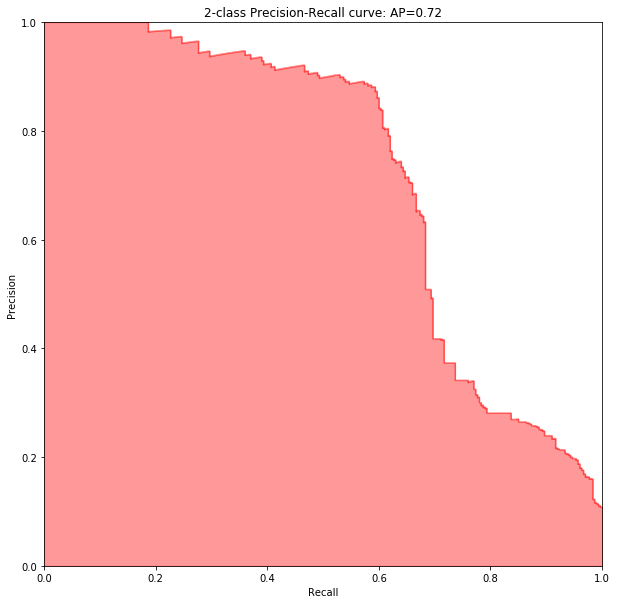

In [16]:
plot_PR_curve(model['logreg'].labels, model['logreg'].oof_predictions)


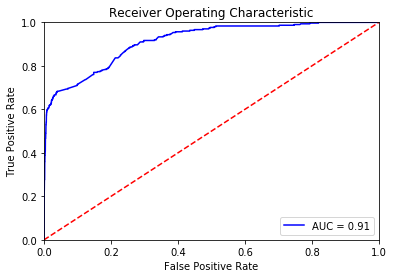

In [17]:
plot_roc_auc_curve(model['logreg'].labels, model['logreg'].oof_predictions)


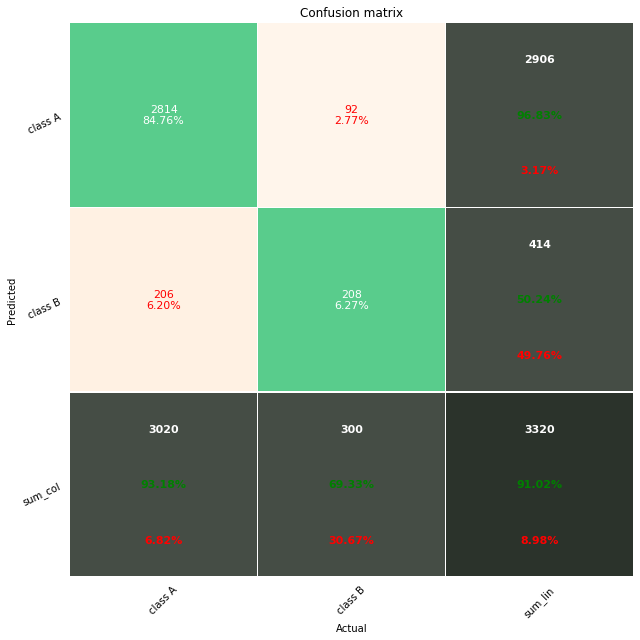

In [18]:
plot_confusion_matrix_from_data(model['logreg'].labels, (model['logreg'].oof_predictions >= model['logreg'].predict_threshold_)*1)

# Simple Feature Engineering

In [19]:
def check_null_categories(column_name):
    df[f'{column_name}_NULL'] = df[f'{column_name}'].isnull()*1
    return df.groupby(f'{column_name}_NULL')['BINARY_TARGET'].mean()


In [20]:
check_null_categories('WEB_TEXT')


WEB_TEXT_NULL
0    0.083732
1    0.094385
Name: BINARY_TARGET, dtype: float64

In [21]:
check_null_categories('TITLE')


TITLE_NULL
0    0.056916
1    0.118297
Name: BINARY_TARGET, dtype: float64

In [22]:
check_null_categories('DESCRIPTION')


DESCRIPTION_NULL
0    0.096465
1    0.081343
Name: BINARY_TARGET, dtype: float64

In [23]:
check_null_categories('KEYWORDS')


KEYWORDS_NULL
0    0.126021
1    0.077954
Name: BINARY_TARGET, dtype: float64